# Imports & basic configuration

In [1]:
import os
import sys
# install the package if not yet installed
try:
    from branch.branch import Net
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.branch import Net
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from branch.galerkin import DGMNet
from branch.bsde import BSDENet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
print(f"torch version: {torch.__version__}")

torch version: 2.0.0+cu117


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Sun Apr 30 15:23:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000                On | 00000000:21:00.0 Off |                  Off |
| 41%   35C    P8               19W / 140W|    864MiB / 16376MiB |      4%      Default |
|                                         |                      |                  N/A |
+---------------------------------

In [4]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    disable_relative=False,
    **kwargs,
):
    if not os.path.isdir('logs/deep_branching/data/'):
        os.makedirs('logs/deep_branching/data/')
    if not os.path.isdir('logs/deep_branching/plot/'):
        os.makedirs('logs/deep_branching/plot/')
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)
    
    problem_name = fname
    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, problem_name=problem_name, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            # note that branch output batch_size x 1 instead of batch_size like other algo
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device), patch=model.patches - 1)[:, 0].detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                branch_rel_error.append(0)
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                dgm_rel_error.append(0)
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                bsde_rel_error.append(0)
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "logs/deep_branching/data/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"logs/deep_branching/plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "logs/deep_branching/data/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

In [5]:
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return ( y[0] - (2 + dim ) / 2 / dim ) * dim * y[1:(dim+1)].sum(dim=0) 
    
def dgm_f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return (( y[0] - (2 + dim ) / 2 / dim ) * dim * y[1:(dim+1)].sum(dim=0) + dim * dim * y[(dim+1):(2*dim+1)].sum(dim=0) / 2 )

def phi_example(x, coordinate=0):
    return torch.exp( T + x.sum(axis=0) / dim ) / (1 + torch.exp( T + x.sum(axis=0) / dim ) )
        
def exact_example(t, x, T):
    xi = t + x.sum(axis=0) / dim 
    return 1 / (1 + np.exp( - xi ) )

t_lo, x_lo, x_hi = 0., -5., 5.
    
x_mid = (x_lo + x_hi) / 2
grid = np.linspace(x_lo, x_hi, 100)

T = 0.1
dim = 15
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 172 seconds; L1 error: 1.38E-03; L2 error: 2.57E-06; rel error: 2.82E-03.
fdb runtime: 567 seconds; total runtime: 739 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 486 seconds; L1 error: 4.13E-02; L2 error: 2.27E-03; rel error: 8.35E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 146 seconds; L1 error: 7.49E-04; L2 error: 7.88E-07; rel error: 1.52E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 171 seconds; L1 error: 6.07E-04; L2 error: 5.74E-07; rel error: 1.21E-03.
fdb runtime: 807 seconds; total runtime: 978 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 487 seconds; L1 error: 4.18E-02; L2 error: 2.32E-03; rel error: 8.47E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 148 seconds; L1 error: 8.58E-04; L2 error: 1.16E-06; rel error: 1.70E-03.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 176 seconds; L1 error: 4.27E-04; L2 error: 2.79E-07; rel error: 8.46E-04.
fdb runtime: 440 seconds; total runtime: 616 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 494 seconds; L1 error: 4.02E-02; L2 error: 2.15E-03; rel error: 8.14E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 149 seconds; L1 error: 9.35E-04; L2 error: 1.36E-06; rel error: 1.87E-03.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 173 seconds; L1 error: 6.99E-04; L2 error: 8.39E-07; rel error: 1.43E-03.
fdb runtime: 612 seconds; total runtime: 785 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 469 seconds; L1 error: 4.00E-02; L2 error: 2.13E-03; rel error: 8.12E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 148 seconds; L1 error: 9.18E-04; L2 error: 1.25E-06; rel error: 1.86E-03.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 176 seconds; L1 error: 7.54E-04; L2 error: 9.63E-07; rel error: 1.51E-03.
fdb runtime: 647 seconds; total runtime: 822 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 458 seconds; L1 error: 4.05E-02; L2 error: 2.19E-03; rel error: 8.21E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 146 seconds; L1 error: 5.71E-04; L2 error: 5.54E-07; rel error: 1.13E-03.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 165 seconds; L1 error: 9.41E-04; L2 error: 2.34E-06; rel error: 1.89E-03.
fdb runtime: 870 seconds; total runtime: 1035 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 450 seconds; L1 error: 4.15E-02; L2 error: 2.29E-03; rel error: 8.42E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 143 seconds; L1 error: 7.94E-04; L2 error: 1.20E-06; rel error: 1.59E-03.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 171 seconds; L1 error: 9.84E-04; L2 error: 1.23E-06; rel error: 1.98E-03.
fdb runtime: 726 seconds; total runtime: 898 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 477 seconds; L1 error: 4.04E-02; L2 error: 2.16E-03; rel error: 8.17E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 140 seconds; L1 error: 6.86E-04; L2 error: 6.80E-07; rel error: 1.36E-03.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 158 seconds; L1 error: 1.11E-03; L2 error: 2.34E-06; rel error: 2.19E-03.
fdb runtime: 675 seconds; total runtime: 833 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 484 seconds; L1 error: 4.07E-02; L2 error: 2.20E-03; rel error: 8.19E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 147 seconds; L1 error: 1.01E-03; L2 error: 1.54E-06; rel error: 2.08E-03.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 177 seconds; L1 error: 5.92E-04; L2 error: 5.10E-07; rel error: 1.19E-03.
fdb runtime: 462 seconds; total runtime: 638 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 484 seconds; L1 error: 4.19E-02; L2 error: 2.33E-03; rel error: 8.50E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 140 seconds; L1 error: 3.35E-04; L2 error: 1.83E-07; rel error: 6.50E-04.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 177 seconds; L1 error: 5.73E-04; L2 error: 5.02E-07; rel error: 1.15E-03.
fdb runtime: 650 seconds; total runtime: 826 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 485 seconds; L1 error: 4.18E-02; L2 error: 2.32E-03; rel error: 8.47E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 146 seconds; L1 error: 8.50E-04; L2 error: 9.61E-07; rel error: 1.76E-03.




######## Summary for deep branching method
runtime:        172
fdb runtime:    646
total runtime:  817
mean L1 error:  8.07E-04
std L1 error:   2.77E-04
mean L2 error:  1.21E-06
std L2 error:   8.27E-07
mean rel error: 1.62E-03
std rel error:  5.64E-04


######## Summary for deep galerkin method
runtime:        477
mean L1 error:  4.10E-02
std L1 error:   6.82E-04
mean L2 error:  2.24E-03
std L2 error:   7.35E-05
mean rel error: 8.30E-02
std rel error:  1.46E-03


######## Summary for deep BSDE method
runtime:        145
mean L1 error:  7.70E-04


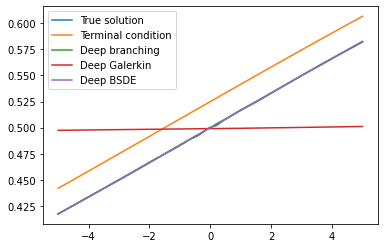

In [6]:
T=0.0001
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 173 seconds; L1 error: 2.34E-03; L2 error: 1.05E-05; rel error: 4.72E-03.
fdb runtime: 544 seconds; total runtime: 718 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 480 seconds; L1 error: 4.18E-02; L2 error: 2.36E-03; rel error: 8.64E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 150 seconds; L1 error: 1.03E+00; L2 error: 1.41E+00; rel error: 2.13E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 184 seconds; L1 error: 1.97E-03; L2 error: 5.73E-06; rel error: 4.17E-03.
fdb runtime: 800 seconds; total runtime: 985 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 458 seconds; L1 error: 4.24E-02; L2 error: 2.42E-03; rel error: 8.77E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 146 seconds; L1 error: 2.62E+01; L2 error: 7.15E+02; rel error: 5.20E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 157 seconds; L1 error: 2.33E-03; L2 error: 1.19E-05; rel error: 4.73E-03.
fdb runtime: 440 seconds; total runtime: 597 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 467 seconds; L1 error: 4.06E-02; L2 error: 2.23E-03; rel error: 8.39E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 147 seconds; L1 error: 8.99E+00; L2 error: 8.24E+01; rel error: 1.81E+01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 154 seconds; L1 error: 2.83E-03; L2 error: 1.51E-05; rel error: 5.81E-03.
fdb runtime: 573 seconds; total runtime: 728 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 486 seconds; L1 error: 4.06E-02; L2 error: 2.23E-03; rel error: 8.41E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 150 seconds; L1 error: 9.92E+00; L2 error: 1.04E+02; rel error: 1.98E+01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 183 seconds; L1 error: 2.20E-03; L2 error: 8.20E-06; rel error: 4.42E-03.
fdb runtime: 624 seconds; total runtime: 807 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 491 seconds; L1 error: 4.12E-02; L2 error: 2.29E-03; rel error: 8.52E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 150 seconds; L1 error: 1.85E+01; L2 error: 3.51E+02; rel error: 3.71E+01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 170 seconds; L1 error: 3.07E-03; L2 error: 1.25E-05; rel error: 6.30E-03.
fdb runtime: 834 seconds; total runtime: 1004 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 503 seconds; L1 error: 4.22E-02; L2 error: 2.41E-03; rel error: 8.74E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 145 seconds; L1 error: 5.79E+00; L2 error: 3.65E+01; rel error: 1.19E+01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 171 seconds; L1 error: 1.96E-03; L2 error: 9.19E-06; rel error: 3.98E-03.
fdb runtime: 707 seconds; total runtime: 878 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 498 seconds; L1 error: 4.09E-02; L2 error: 2.25E-03; rel error: 8.45E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 150 seconds; L1 error: 6.43E+00; L2 error: 4.78E+01; rel error: 1.25E+01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 164 seconds; L1 error: 2.72E-03; L2 error: 1.20E-05; rel error: 5.58E-03.
fdb runtime: 670 seconds; total runtime: 834 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 499 seconds; L1 error: 4.07E-02; L2 error: 2.22E-03; rel error: 8.37E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 150 seconds; L1 error: 1.10E+01; L2 error: 1.43E+02; rel error: 2.31E+01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 175 seconds; L1 error: 4.21E-03; L2 error: 2.79E-05; rel error: 8.75E-03.
fdb runtime: 457 seconds; total runtime: 632 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 501 seconds; L1 error: 4.26E-02; L2 error: 2.45E-03; rel error: 8.82E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 149 seconds; L1 error: 1.60E+01; L2 error: 2.89E+02; rel error: 3.28E+01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 172 seconds; L1 error: 3.09E-03; L2 error: 1.43E-05; rel error: 6.23E-03.
fdb runtime: 643 seconds; total runtime: 815 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 483 seconds; L1 error: 4.24E-02; L2 error: 2.42E-03; rel error: 8.76E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 150 seconds; L1 error: 1.37E+01; L2 error: 2.18E+02; rel error: 2.83E+01.




######## Summary for deep branching method
runtime:        170
fdb runtime:    629
total runtime:  800
mean L1 error:  2.67E-03
std L1 error:   6.46E-04
mean L2 error:  1.27E-05
std L2 error:   5.71E-06
mean rel error: 5.47E-03
std rel error:  1.35E-03


######## Summary for deep galerkin method
runtime:        487
mean L1 error:  4.15E-02
std L1 error:   7.75E-04
mean L2 error:  2.33E-03
std L2 error:   8.84E-05
mean rel error: 8.59E-02
std rel error:  1.69E-03


######## Summary for deep BSDE method
runtime:        149
mean L1 error:  1.18E+01


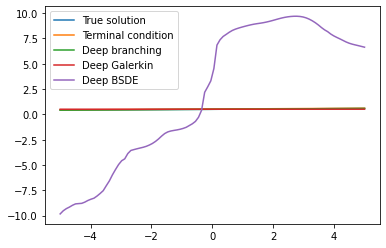

In [6]:
T=0.05
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 173 seconds; L1 error: 1.02E-02; L2 error: 1.50E-04; rel error: 2.03E-02.
fdb runtime: 547 seconds; total runtime: 720 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 474 seconds; L1 error: 4.37E-02; L2 error: 2.67E-03; rel error: 9.19E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 149 seconds; L1 error: 9.00E+00; L2 error: 9.70E+01; rel error: 1.85E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 178 seconds; L1 error: 5.87E-03; L2 error: 5.03E-05; rel error: 1.23E-02.
fdb runtime: 805 seconds; total runtime: 982 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 499 seconds; L1 error: 4.43E-02; L2 error: 2.75E-03; rel error: 9.33E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 148 seconds; L1 error: 6.61E+00; L2 error: 4.54E+01; rel error: 1.32E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 165 seconds; L1 error: 9.26E-03; L2 error: 2.05E-04; rel error: 1.90E-02.
fdb runtime: 441 seconds; total runtime: 606 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 487 seconds; L1 error: 4.23E-02; L2 error: 2.50E-03; rel error: 8.89E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 147 seconds; L1 error: 3.68E+00; L2 error: 1.61E+01; rel error: 7.13E+00.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 179 seconds; L1 error: 1.13E-02; L2 error: 2.60E-04; rel error: 2.37E-02.
fdb runtime: 577 seconds; total runtime: 756 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 480 seconds; L1 error: 4.26E-02; L2 error: 2.55E-03; rel error: 8.97E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 149 seconds; L1 error: 5.35E+00; L2 error: 3.25E+01; rel error: 1.10E+01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 176 seconds; L1 error: 1.22E-02; L2 error: 2.78E-04; rel error: 2.47E-02.
fdb runtime: 624 seconds; total runtime: 800 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 495 seconds; L1 error: 4.32E-02; L2 error: 2.62E-03; rel error: 9.10E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 150 seconds; L1 error: 2.98E+00; L2 error: 1.21E+01; rel error: 6.11E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 175 seconds; L1 error: 8.05E-03; L2 error: 9.43E-05; rel error: 1.61E-02.
fdb runtime: 832 seconds; total runtime: 1007 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 497 seconds; L1 error: 4.43E-02; L2 error: 2.75E-03; rel error: 9.33E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 151 seconds; L1 error: 5.09E+00; L2 error: 3.30E+01; rel error: 1.07E+01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 180 seconds; L1 error: 5.89E-03; L2 error: 8.88E-05; rel error: 1.17E-02.
fdb runtime: 706 seconds; total runtime: 887 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 487 seconds; L1 error: 4.28E-02; L2 error: 2.56E-03; rel error: 9.00E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 149 seconds; L1 error: 6.95E+00; L2 error: 5.59E+01; rel error: 1.44E+01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 166 seconds; L1 error: 6.87E-03; L2 error: 1.10E-04; rel error: 1.43E-02.
fdb runtime: 668 seconds; total runtime: 834 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 502 seconds; L1 error: 4.21E-02; L2 error: 2.46E-03; rel error: 8.82E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 149 seconds; L1 error: 5.61E+00; L2 error: 3.45E+01; rel error: 1.13E+01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 176 seconds; L1 error: 1.03E-02; L2 error: 1.87E-04; rel error: 2.05E-02.
fdb runtime: 458 seconds; total runtime: 634 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 494 seconds; L1 error: 4.46E-02; L2 error: 2.79E-03; rel error: 9.40E-02.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 148 seconds; L1 error: 2.55E+00; L2 error: 8.11E+00; rel error: 5.17E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 182 seconds; L1 error: 8.99E-03; L2 error: 1.20E-04; rel error: 1.79E-02.
fdb runtime: 644 seconds; total runtime: 826 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 497 seconds; L1 error: 4.43E-02; L2 error: 2.74E-03; rel error: 9.32E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 147 seconds; L1 error: 1.33E+01; L2 error: 1.92E+02; rel error: 2.65E+01.




######## Summary for deep branching method
runtime:        175
fdb runtime:    630
total runtime:  805
mean L1 error:  8.89E-03
std L1 error:   2.08E-03
mean L2 error:  1.54E-04
std L2 error:   7.22E-05
mean rel error: 1.81E-02
std rel error:  4.24E-03


######## Summary for deep galerkin method
runtime:        491
mean L1 error:  4.34E-02
std L1 error:   8.99E-04
mean L2 error:  2.64E-03
std L2 error:   1.12E-04
mean rel error: 9.14E-02
std rel error:  1.98E-03


######## Summary for deep BSDE method
runtime:        149
mean L1 error:  6.11E+00


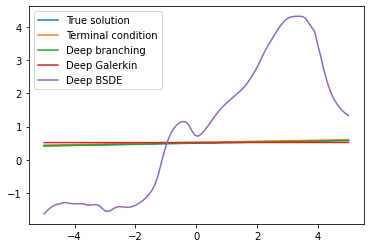

In [7]:
T=0.10
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 171 seconds; L1 error: 5.57E-03; L2 error: 5.31E-05; rel error: 1.15E-02.
fdb runtime: 549 seconds; total runtime: 720 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 495 seconds; L1 error: 4.69E-02; L2 error: 3.21E-03; rel error: 1.00E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 150 seconds; L1 error: 4.41E+00; L2 error: 2.55E+01; rel error: 8.61E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 180 seconds; L1 error: 7.21E-03; L2 error: 8.29E-05; rel error: 1.52E-02.
fdb runtime: 808 seconds; total runtime: 987 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 495 seconds; L1 error: 4.76E-02; L2 error: 3.30E-03; rel error: 1.01E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 150 seconds; L1 error: 1.23E+01; L2 error: 1.60E+02; rel error: 2.52E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 181 seconds; L1 error: 1.14E-02; L2 error: 2.58E-04; rel error: 2.40E-02.
fdb runtime: 442 seconds; total runtime: 623 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 487 seconds; L1 error: 4.53E-02; L2 error: 2.99E-03; rel error: 9.65E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 149 seconds; L1 error: 6.95E+00; L2 error: 5.13E+01; rel error: 1.42E+01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 179 seconds; L1 error: 1.04E-02; L2 error: 1.87E-04; rel error: 2.13E-02.
fdb runtime: 578 seconds; total runtime: 757 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 481 seconds; L1 error: 4.59E-02; L2 error: 3.08E-03; rel error: 9.80E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 148 seconds; L1 error: 2.95E+00; L2 error: 1.12E+01; rel error: 5.83E+00.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 185 seconds; L1 error: 1.10E-02; L2 error: 2.02E-04; rel error: 2.25E-02.
fdb runtime: 628 seconds; total runtime: 812 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 472 seconds; L1 error: 4.66E-02; L2 error: 3.17E-03; rel error: 9.95E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 150 seconds; L1 error: 6.62E+00; L2 error: 5.03E+01; rel error: 1.33E+01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 168 seconds; L1 error: 8.88E-03; L2 error: 1.20E-04; rel error: 1.80E-02.
fdb runtime: 836 seconds; total runtime: 1004 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 477 seconds; L1 error: 4.77E-02; L2 error: 3.32E-03; rel error: 1.02E-01.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 151 seconds; L1 error: 3.74E+00; L2 error: 1.91E+01; rel error: 7.86E+00.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 171 seconds; L1 error: 1.10E-02; L2 error: 1.98E-04; rel error: 2.24E-02.
fdb runtime: 709 seconds; total runtime: 880 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 483 seconds; L1 error: 4.60E-02; L2 error: 3.10E-03; rel error: 9.82E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 146 seconds; L1 error: 1.85E+01; L2 error: 3.55E+02; rel error: 3.72E+01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 165 seconds; L1 error: 7.70E-03; L2 error: 1.17E-04; rel error: 1.60E-02.
fdb runtime: 669 seconds; total runtime: 834 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 485 seconds; L1 error: 4.48E-02; L2 error: 2.91E-03; rel error: 9.53E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 145 seconds; L1 error: 6.16E+00; L2 error: 4.17E+01; rel error: 1.22E+01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 174 seconds; L1 error: 7.42E-03; L2 error: 1.54E-04; rel error: 1.57E-02.
fdb runtime: 457 seconds; total runtime: 631 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 482 seconds; L1 error: 4.80E-02; L2 error: 3.36E-03; rel error: 1.02E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 150 seconds; L1 error: 7.18E+00; L2 error: 5.58E+01; rel error: 1.48E+01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 174 seconds; L1 error: 7.78E-03; L2 error: 1.83E-04; rel error: 1.66E-02.
fdb runtime: 645 seconds; total runtime: 820 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 495 seconds; L1 error: 4.76E-02; L2 error: 3.29E-03; rel error: 1.01E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 146 seconds; L1 error: 4.25E+00; L2 error: 2.12E+01; rel error: 8.65E+00.




######## Summary for deep branching method
runtime:        175
fdb runtime:    632
total runtime:  807
mean L1 error:  8.83E-03
std L1 error:   1.90E-03
mean L2 error:  1.55E-04
std L2 error:   5.89E-05
mean rel error: 1.83E-02
std rel error:  3.83E-03


######## Summary for deep galerkin method
runtime:        485
mean L1 error:  4.66E-02
std L1 error:   1.04E-03
mean L2 error:  3.17E-03
std L2 error:   1.43E-04
mean rel error: 9.94E-02
std rel error:  2.28E-03


######## Summary for deep BSDE method
runtime:        149
mean L1 error:  7.30E+00


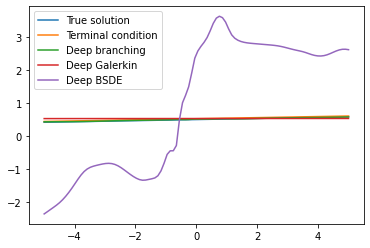

In [8]:
T=0.15
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 127 seconds; L1 error: 6.51E-03; L2 error: 7.27E-05; rel error: 1.36E-02.
fdb runtime: 590 seconds; total runtime: 717 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 350 seconds; L1 error: 5.15E-02; L2 error: 3.97E-03; rel error: 1.11E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 87 seconds; L1 error: 2.66E+00; L2 error: 8.51E+00; rel error: 5.48E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 129 seconds; L1 error: 9.38E-03; L2 error: 1.49E-04; rel error: 2.01E-02.
fdb runtime: 882 seconds; total runtime: 1010 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 350 seconds; L1 error: 5.22E-02; L2 error: 4.07E-03; rel error: 1.12E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 86 seconds; L1 error: 3.22E+00; L2 error: 1.23E+01; rel error: 6.34E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 123 seconds; L1 error: 1.30E-02; L2 error: 3.41E-04; rel error: 2.73E-02.
fdb runtime: 486 seconds; total runtime: 609 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 399 seconds; L1 error: 4.96E-02; L2 error: 3.69E-03; rel error: 1.07E-01.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 85 seconds; L1 error: 2.99E+00; L2 error: 1.06E+01; rel error: 6.23E+00.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 118 seconds; L1 error: 1.26E-02; L2 error: 2.40E-04; rel error: 2.55E-02.
fdb runtime: 635 seconds; total runtime: 754 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 448 seconds; L1 error: 5.06E-02; L2 error: 3.84E-03; rel error: 1.09E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 100 seconds; L1 error: 3.08E+00; L2 error: 1.08E+01; rel error: 6.23E+00.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 161 seconds; L1 error: 1.33E-02; L2 error: 2.55E-04; rel error: 2.77E-02.
fdb runtime: 676 seconds; total runtime: 837 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 423 seconds; L1 error: 5.14E-02; L2 error: 3.95E-03; rel error: 1.11E-01.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 100 seconds; L1 error: 3.60E+00; L2 error: 1.32E+01; rel error: 7.25E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 144 seconds; L1 error: 1.03E-02; L2 error: 1.88E-04; rel error: 2.18E-02.
fdb runtime: 932 seconds; total runtime: 1076 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 400 seconds; L1 error: 5.24E-02; L2 error: 4.11E-03; rel error: 1.13E-01.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 105 seconds; L1 error: 6.64E-01; L2 error: 5.12E-01; rel error: 1.39E+00.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 144 seconds; L1 error: 1.13E-02; L2 error: 1.85E-04; rel error: 2.41E-02.
fdb runtime: 738 seconds; total runtime: 882 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 417 seconds; L1 error: 5.07E-02; L2 error: 3.86E-03; rel error: 1.09E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 105 seconds; L1 error: 8.75E-01; L2 error: 1.20E+00; rel error: 1.67E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 138 seconds; L1 error: 1.02E-02; L2 error: 1.46E-04; rel error: 2.17E-02.
fdb runtime: 700 seconds; total runtime: 839 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 422 seconds; L1 error: 4.89E-02; L2 error: 3.57E-03; rel error: 1.05E-01.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 103 seconds; L1 error: 4.22E+00; L2 error: 2.07E+01; rel error: 8.25E+00.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 142 seconds; L1 error: 9.55E-03; L2 error: 1.33E-04; rel error: 2.04E-02.
fdb runtime: 486 seconds; total runtime: 628 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 417 seconds; L1 error: 5.27E-02; L2 error: 4.15E-03; rel error: 1.13E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 97 seconds; L1 error: 5.29E+00; L2 error: 3.76E+01; rel error: 1.12E+01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 154 seconds; L1 error: 8.59E-03; L2 error: 1.49E-04; rel error: 1.80E-02.
fdb runtime: 671 seconds; total runtime: 825 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 414 seconds; L1 error: 5.22E-02; L2 error: 4.06E-03; rel error: 1.12E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 104 seconds; L1 error: 2.50E+00; L2 error: 9.82E+00; rel error: 5.38E+00.




######## Summary for deep branching method
runtime:        138
fdb runtime:    680
total runtime:  818
mean L1 error:  1.05E-02
std L1 error:   2.02E-03
mean L2 error:  1.86E-04
std L2 error:   7.18E-05
mean rel error: 2.20E-02
std rel error:  4.13E-03


######## Summary for deep galerkin method
runtime:        404
mean L1 error:  5.12E-02
std L1 error:   1.19E-03
mean L2 error:  3.93E-03
std L2 error:   1.79E-04
mean rel error: 1.10E-01
std rel error:  2.59E-03


######## Summary for deep BSDE method
runtime:        97
mean L1 error:  2.91E+00
s

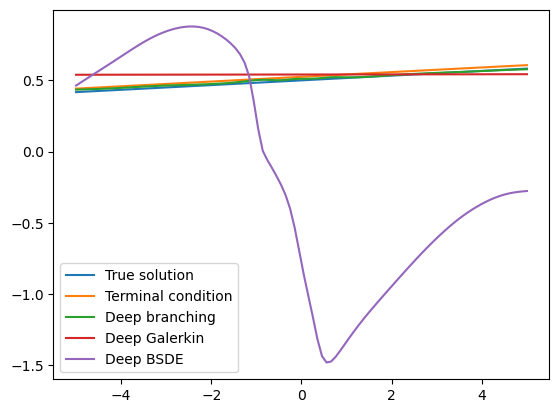

In [6]:
T=0.20
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 166 seconds; L1 error: 9.69E-03; L2 error: 1.70E-04; rel error: 2.03E-02.
fdb runtime: 573 seconds; total runtime: 739 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 459 seconds; L1 error: 5.74E-02; L2 error: 4.94E-03; rel error: 1.24E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 121 seconds; L1 error: 2.53E+00; L2 error: 7.99E+00; rel error: 4.95E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 167 seconds; L1 error: 1.16E-02; L2 error: 2.28E-04; rel error: 2.49E-02.
fdb runtime: 839 seconds; total runtime: 1006 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 480 seconds; L1 error: 5.81E-02; L2 error: 5.07E-03; rel error: 1.25E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 108 seconds; L1 error: 3.23E+00; L2 error: 1.12E+01; rel error: 6.53E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 172 seconds; L1 error: 1.41E-02; L2 error: 2.45E-04; rel error: 2.94E-02.
fdb runtime: 457 seconds; total runtime: 630 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 480 seconds; L1 error: 5.53E-02; L2 error: 4.59E-03; rel error: 1.19E-01.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 115 seconds; L1 error: 4.96E-01; L2 error: 3.85E-01; rel error: 1.06E+00.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 170 seconds; L1 error: 1.36E-02; L2 error: 2.74E-04; rel error: 2.85E-02.
fdb runtime: 598 seconds; total runtime: 769 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 476 seconds; L1 error: 5.67E-02; L2 error: 4.82E-03; rel error: 1.22E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 114 seconds; L1 error: 2.65E+00; L2 error: 8.92E+00; rel error: 5.57E+00.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 181 seconds; L1 error: 1.61E-02; L2 error: 3.73E-04; rel error: 3.36E-02.
fdb runtime: 642 seconds; total runtime: 823 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 507 seconds; L1 error: 5.76E-02; L2 error: 4.95E-03; rel error: 1.24E-01.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 117 seconds; L1 error: 7.64E-01; L2 error: 7.35E-01; rel error: 1.54E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 169 seconds; L1 error: 1.00E-02; L2 error: 1.78E-04; rel error: 2.17E-02.
fdb runtime: 852 seconds; total runtime: 1021 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 508 seconds; L1 error: 5.85E-02; L2 error: 5.12E-03; rel error: 1.26E-01.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 114 seconds; L1 error: 3.80E+00; L2 error: 1.72E+01; rel error: 7.89E+00.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 173 seconds; L1 error: 1.28E-02; L2 error: 2.55E-04; rel error: 2.75E-02.
fdb runtime: 724 seconds; total runtime: 897 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 504 seconds; L1 error: 5.68E-02; L2 error: 4.85E-03; rel error: 1.23E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 115 seconds; L1 error: 2.18E+00; L2 error: 6.01E+00; rel error: 4.52E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 170 seconds; L1 error: 1.24E-02; L2 error: 1.96E-04; rel error: 2.61E-02.
fdb runtime: 684 seconds; total runtime: 853 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 502 seconds; L1 error: 5.43E-02; L2 error: 4.45E-03; rel error: 1.17E-01.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 114 seconds; L1 error: 5.18E-01; L2 error: 3.72E-01; rel error: 1.02E+00.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 177 seconds; L1 error: 1.30E-02; L2 error: 2.38E-04; rel error: 2.78E-02.
fdb runtime: 471 seconds; total runtime: 649 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 486 seconds; L1 error: 5.87E-02; L2 error: 5.16E-03; rel error: 1.27E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 113 seconds; L1 error: 2.17E+00; L2 error: 5.45E+00; rel error: 4.32E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 174 seconds; L1 error: 7.80E-03; L2 error: 8.92E-05; rel error: 1.64E-02.
fdb runtime: 671 seconds; total runtime: 845 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 479 seconds; L1 error: 5.81E-02; L2 error: 5.05E-03; rel error: 1.25E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 116 seconds; L1 error: 1.39E+00; L2 error: 2.93E+00; rel error: 2.96E+00.




######## Summary for deep branching method
runtime:        172
fdb runtime:    651
total runtime:  823
mean L1 error:  1.21E-02
std L1 error:   2.29E-03
mean L2 error:  2.25E-04
std L2 error:   7.08E-05
mean rel error: 2.56E-02
std rel error:  4.73E-03


######## Summary for deep galerkin method
runtime:        488
mean L1 error:  5.72E-02
std L1 error:   1.35E-03
mean L2 error:  4.90E-03
std L2 error:   2.18E-04
mean rel error: 1.23E-01
std rel error:  2.90E-03


######## Summary for deep BSDE method
runtime:        115
mean L1 error:  1.97E+00


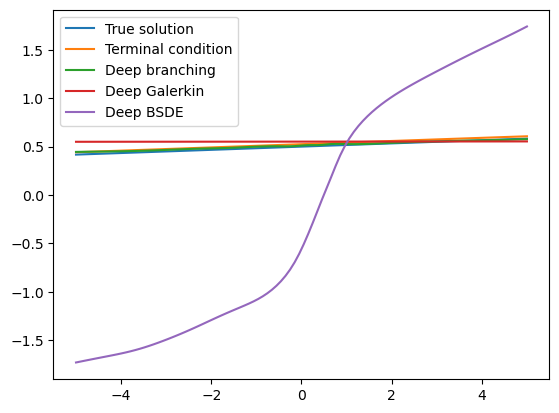

In [7]:
T=0.25
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 170 seconds; L1 error: 1.20E-02; L2 error: 2.60E-04; rel error: 2.53E-02.
fdb runtime: 572 seconds; total runtime: 742 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 477 seconds; L1 error: 6.46E-02; L2 error: 6.13E-03; rel error: 1.39E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 109 seconds; L1 error: 4.06E+00; L2 error: 1.79E+01; rel error: 8.20E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 187 seconds; L1 error: 1.32E-02; L2 error: 3.11E-04; rel error: 2.87E-02.
fdb runtime: 857 seconds; total runtime: 1043 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 465 seconds; L1 error: 6.53E-02; L2 error: 6.28E-03; rel error: 1.41E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 104 seconds; L1 error: 1.65E+00; L2 error: 3.33E+00; rel error: 3.36E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 178 seconds; L1 error: 1.66E-02; L2 error: 3.39E-04; rel error: 3.48E-02.
fdb runtime: 478 seconds; total runtime: 656 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 487 seconds; L1 error: 6.22E-02; L2 error: 5.71E-03; rel error: 1.34E-01.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 110 seconds; L1 error: 2.29E+00; L2 error: 6.76E+00; rel error: 4.63E+00.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 168 seconds; L1 error: 1.62E-02; L2 error: 3.72E-04; rel error: 3.43E-02.
fdb runtime: 595 seconds; total runtime: 763 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 473 seconds; L1 error: 6.42E-02; L2 error: 6.01E-03; rel error: 1.38E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 116 seconds; L1 error: 4.34E-01; L2 error: 2.91E-01; rel error: 8.58E-01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 190 seconds; L1 error: 1.72E-02; L2 error: 3.76E-04; rel error: 3.56E-02.
fdb runtime: 656 seconds; total runtime: 846 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 492 seconds; L1 error: 6.51E-02; L2 error: 6.16E-03; rel error: 1.40E-01.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 110 seconds; L1 error: 6.79E-01; L2 error: 6.49E-01; rel error: 1.36E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 160 seconds; L1 error: 1.34E-02; L2 error: 2.96E-04; rel error: 2.89E-02.
fdb runtime: 879 seconds; total runtime: 1039 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 489 seconds; L1 error: 6.59E-02; L2 error: 6.35E-03; rel error: 1.42E-01.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 116 seconds; L1 error: 6.24E-01; L2 error: 6.27E-01; rel error: 1.20E+00.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 163 seconds; L1 error: 1.46E-02; L2 error: 3.18E-04; rel error: 3.12E-02.
fdb runtime: 739 seconds; total runtime: 902 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 468 seconds; L1 error: 6.43E-02; L2 error: 6.06E-03; rel error: 1.38E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 115 seconds; L1 error: 2.18E+00; L2 error: 6.01E+00; rel error: 4.52E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 154 seconds; L1 error: 1.42E-02; L2 error: 2.79E-04; rel error: 3.00E-02.
fdb runtime: 693 seconds; total runtime: 848 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 477 seconds; L1 error: 6.11E-02; L2 error: 5.54E-03; rel error: 1.32E-01.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 117 seconds; L1 error: 8.86E-01; L2 error: 9.78E-01; rel error: 1.87E+00.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 173 seconds; L1 error: 1.36E-02; L2 error: 2.94E-04; rel error: 2.94E-02.
fdb runtime: 459 seconds; total runtime: 632 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 471 seconds; L1 error: 6.61E-02; L2 error: 6.39E-03; rel error: 1.42E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 112 seconds; L1 error: 1.78E+00; L2 error: 3.71E+00; rel error: 3.50E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 187 seconds; L1 error: 1.31E-02; L2 error: 3.00E-04; rel error: 2.85E-02.
fdb runtime: 645 seconds; total runtime: 832 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 486 seconds; L1 error: 6.53E-02; L2 error: 6.26E-03; rel error: 1.41E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 113 seconds; L1 error: 1.68E+00; L2 error: 3.41E+00; rel error: 3.36E+00.




######## Summary for deep branching method
runtime:        173
fdb runtime:    657
total runtime:  830
mean L1 error:  1.44E-02
std L1 error:   1.63E-03
mean L2 error:  3.14E-04
std L2 error:   3.58E-05
mean rel error: 3.07E-02
std rel error:  3.12E-03


######## Summary for deep galerkin method
runtime:        479
mean L1 error:  6.44E-02
std L1 error:   1.51E-03
mean L2 error:  6.09E-03
std L2 error:   2.61E-04
mean rel error: 1.39E-01
std rel error:  3.21E-03


######## Summary for deep BSDE method
runtime:        112
mean L1 error:  1.63E+00


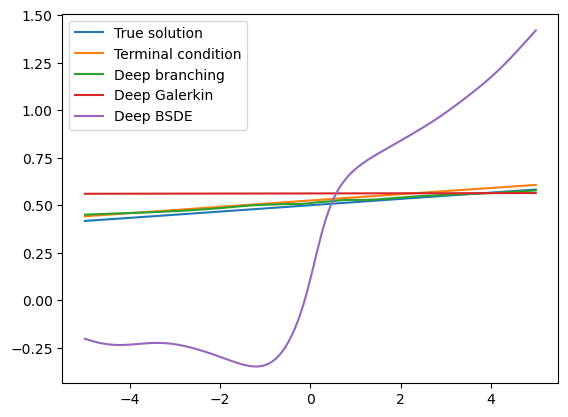

In [8]:
T=0.30
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 171 seconds; L1 error: 1.24E-02; L2 error: 2.39E-04; rel error: 2.64E-02.
fdb runtime: 556 seconds; total runtime: 727 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 488 seconds; L1 error: 7.32E-02; L2 error: 7.54E-03; rel error: 1.57E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 106 seconds; L1 error: 4.29E-01; L2 error: 3.17E-01; rel error: 9.12E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 180 seconds; L1 error: 1.40E-02; L2 error: 3.36E-04; rel error: 3.02E-02.
fdb runtime: 848 seconds; total runtime: 1028 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 485 seconds; L1 error: 7.39E-02; L2 error: 7.70E-03; rel error: 1.58E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 106 seconds; L1 error: 2.36E+00; L2 error: 7.77E+00; rel error: 4.95E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 171 seconds; L1 error: 2.14E-02; L2 error: 5.68E-04; rel error: 4.44E-02.
fdb runtime: 457 seconds; total runtime: 628 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 496 seconds; L1 error: 7.05E-02; L2 error: 7.03E-03; rel error: 1.51E-01.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 102 seconds; L1 error: 2.18E+00; L2 error: 5.85E+00; rel error: 4.50E+00.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 173 seconds; L1 error: 1.82E-02; L2 error: 4.50E-04; rel error: 3.86E-02.
fdb runtime: 600 seconds; total runtime: 773 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 474 seconds; L1 error: 7.30E-02; L2 error: 7.41E-03; rel error: 1.56E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 114 seconds; L1 error: 4.34E-01; L2 error: 2.91E-01; rel error: 8.58E-01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 176 seconds; L1 error: 1.66E-02; L2 error: 3.92E-04; rel error: 3.52E-02.
fdb runtime: 669 seconds; total runtime: 846 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 499 seconds; L1 error: 7.39E-02; L2 error: 7.59E-03; rel error: 1.58E-01.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 111 seconds; L1 error: 8.25E-01; L2 error: 9.01E-01; rel error: 1.69E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 170 seconds; L1 error: 1.54E-02; L2 error: 3.58E-04; rel error: 3.29E-02.
fdb runtime: 860 seconds; total runtime: 1029 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 489 seconds; L1 error: 7.46E-02; L2 error: 7.78E-03; rel error: 1.60E-01.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 118 seconds; L1 error: 6.24E-01; L2 error: 6.27E-01; rel error: 1.20E+00.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 174 seconds; L1 error: 1.76E-02; L2 error: 4.70E-04; rel error: 3.80E-02.
fdb runtime: 711 seconds; total runtime: 885 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 467 seconds; L1 error: 7.32E-02; L2 error: 7.48E-03; rel error: 1.57E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 111 seconds; L1 error: 2.18E+00; L2 error: 6.01E+00; rel error: 4.52E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 161 seconds; L1 error: 1.76E-02; L2 error: 4.02E-04; rel error: 3.71E-02.
fdb runtime: 674 seconds; total runtime: 835 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 493 seconds; L1 error: 6.92E-02; L2 error: 6.83E-03; rel error: 1.49E-01.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 120 seconds; L1 error: 8.86E-01; L2 error: 9.78E-01; rel error: 1.87E+00.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 175 seconds; L1 error: 1.60E-02; L2 error: 3.94E-04; rel error: 3.46E-02.
fdb runtime: 462 seconds; total runtime: 637 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 496 seconds; L1 error: 7.47E-02; L2 error: 7.83E-03; rel error: 1.60E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 114 seconds; L1 error: 9.90E-01; L2 error: 1.23E+00; rel error: 2.05E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 176 seconds; L1 error: 1.59E-02; L2 error: 4.08E-04; rel error: 3.44E-02.
fdb runtime: 646 seconds; total runtime: 822 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 479 seconds; L1 error: 7.38E-02; L2 error: 7.68E-03; rel error: 1.58E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 98 seconds; L1 error: 6.85E-01; L2 error: 6.06E-01; rel error: 1.35E+00.




######## Summary for deep branching method
runtime:        173
fdb runtime:    648
total runtime:  821
mean L1 error:  1.65E-02
std L1 error:   2.33E-03
mean L2 error:  4.02E-04
std L2 error:   8.21E-05
mean rel error: 3.52E-02
std rel error:  4.65E-03


######## Summary for deep galerkin method
runtime:        487
mean L1 error:  7.30E-02
std L1 error:   1.69E-03
mean L2 error:  7.49E-03
std L2 error:   3.07E-04
mean rel error: 1.57E-01
std rel error:  3.53E-03


######## Summary for deep BSDE method
runtime:        110
mean L1 error:  1.16E+00
s

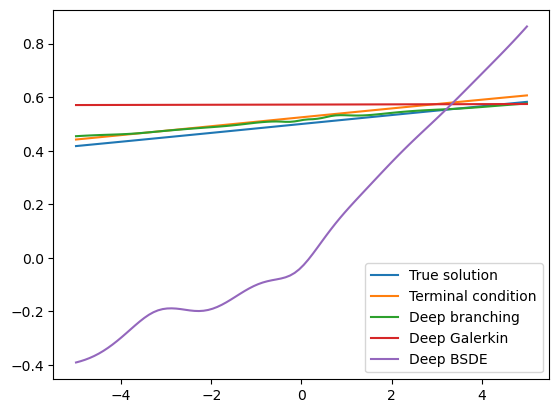

In [9]:
T=0.35
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 157 seconds; L1 error: 1.36E-02; L2 error: 2.58E-04; rel error: 2.87E-02.
fdb runtime: 550 seconds; total runtime: 706 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 498 seconds; L1 error: 8.30E-02; L2 error: 9.14E-03; rel error: 1.77E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 105 seconds; L1 error: 4.29E-01; L2 error: 3.17E-01; rel error: 9.12E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 168 seconds; L1 error: 1.51E-02; L2 error: 3.79E-04; rel error: 3.28E-02.
fdb runtime: 810 seconds; total runtime: 978 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 487 seconds; L1 error: 8.37E-02; L2 error: 9.33E-03; rel error: 1.79E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 94 seconds; L1 error: 5.21E-01; L2 error: 4.08E-01; rel error: 1.10E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 164 seconds; L1 error: 2.09E-02; L2 error: 6.30E-04; rel error: 4.44E-02.
fdb runtime: 444 seconds; total runtime: 609 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 480 seconds; L1 error: 8.01E-02; L2 error: 8.55E-03; rel error: 1.71E-01.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 101 seconds; L1 error: 2.18E+00; L2 error: 5.85E+00; rel error: 4.50E+00.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 172 seconds; L1 error: 2.04E-02; L2 error: 5.65E-04; rel error: 4.33E-02.
fdb runtime: 580 seconds; total runtime: 752 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 490 seconds; L1 error: 8.31E-02; L2 error: 9.02E-03; rel error: 1.77E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 115 seconds; L1 error: 2.78E+00; L2 error: 8.50E+00; rel error: 5.62E+00.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 180 seconds; L1 error: 1.97E-02; L2 error: 5.67E-04; rel error: 4.21E-02.
fdb runtime: 628 seconds; total runtime: 808 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 501 seconds; L1 error: 8.39E-02; L2 error: 9.24E-03; rel error: 1.79E-01.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 111 seconds; L1 error: 8.74E-01; L2 error: 1.13E+00; rel error: 1.81E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 169 seconds; L1 error: 1.83E-02; L2 error: 6.04E-04; rel error: 3.98E-02.
fdb runtime: 838 seconds; total runtime: 1007 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 499 seconds; L1 error: 8.45E-02; L2 error: 9.43E-03; rel error: 1.80E-01.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 121 seconds; L1 error: 6.24E-01; L2 error: 6.27E-01; rel error: 1.20E+00.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 181 seconds; L1 error: 1.96E-02; L2 error: 5.91E-04; rel error: 4.22E-02.
fdb runtime: 709 seconds; total runtime: 890 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 463 seconds; L1 error: 8.34E-02; L2 error: 9.11E-03; rel error: 1.78E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 114 seconds; L1 error: 1.40E+00; L2 error: 2.03E+00; rel error: 2.82E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 170 seconds; L1 error: 1.87E-02; L2 error: 4.46E-04; rel error: 3.95E-02.
fdb runtime: 673 seconds; total runtime: 843 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 493 seconds; L1 error: 7.85E-02; L2 error: 8.33E-03; rel error: 1.68E-01.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 119 seconds; L1 error: 8.86E-01; L2 error: 9.78E-01; rel error: 1.87E+00.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 167 seconds; L1 error: 1.84E-02; L2 error: 5.10E-04; rel error: 3.97E-02.
fdb runtime: 459 seconds; total runtime: 626 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 482 seconds; L1 error: 8.46E-02; L2 error: 9.48E-03; rel error: 1.80E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 111 seconds; L1 error: 9.90E-01; L2 error: 1.23E+00; rel error: 2.05E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 177 seconds; L1 error: 1.78E-02; L2 error: 5.00E-04; rel error: 3.85E-02.
fdb runtime: 648 seconds; total runtime: 825 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 507 seconds; L1 error: 8.36E-02; L2 error: 9.30E-03; rel error: 1.78E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 121 seconds; L1 error: 6.85E-01; L2 error: 6.06E-01; rel error: 1.35E+00.




######## Summary for deep branching method
runtime:        170
fdb runtime:    634
total runtime:  804
mean L1 error:  1.82E-02
std L1 error:   2.17E-03
mean L2 error:  5.05E-04
std L2 error:   1.10E-04
mean rel error: 3.91E-02
std rel error:  4.62E-03


######## Summary for deep galerkin method
runtime:        490
mean L1 error:  8.28E-02
std L1 error:   1.86E-03
mean L2 error:  9.09E-03
std L2 error:   3.56E-04
mean rel error: 1.77E-01
std rel error:  3.86E-03


######## Summary for deep BSDE method
runtime:        111
mean L1 error:  1.14E+00


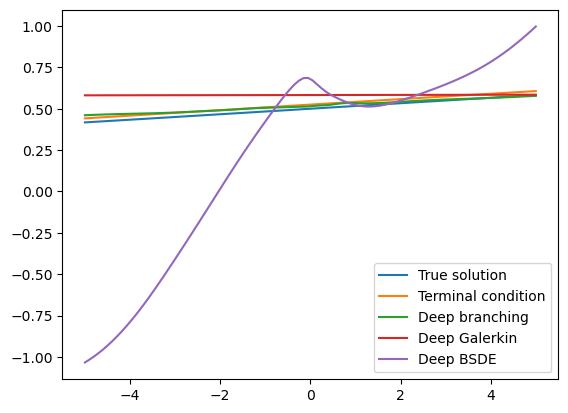

In [10]:
T=0.40
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 170 seconds; L1 error: 1.68E-02; L2 error: 4.21E-04; rel error: 3.57E-02.
fdb runtime: 551 seconds; total runtime: 721 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 481 seconds; L1 error: 9.32E-02; L2 error: 1.10E-02; rel error: 1.98E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 119 seconds; L1 error: 4.29E-01; L2 error: 3.17E-01; rel error: 9.12E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 183 seconds; L1 error: 1.80E-02; L2 error: 5.41E-04; rel error: 3.91E-02.
fdb runtime: 811 seconds; total runtime: 994 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 478 seconds; L1 error: 9.40E-02; L2 error: 1.12E-02; rel error: 1.99E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 110 seconds; L1 error: 5.21E-01; L2 error: 4.08E-01; rel error: 1.10E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 172 seconds; L1 error: 2.14E-02; L2 error: 6.57E-04; rel error: 4.54E-02.
fdb runtime: 447 seconds; total runtime: 619 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 507 seconds; L1 error: 9.02E-02; L2 error: 1.03E-02; rel error: 1.91E-01.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 121 seconds; L1 error: 2.18E+00; L2 error: 5.85E+00; rel error: 4.50E+00.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 179 seconds; L1 error: 2.34E-02; L2 error: 7.51E-04; rel error: 4.98E-02.
fdb runtime: 580 seconds; total runtime: 758 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 457 seconds; L1 error: 9.34E-02; L2 error: 1.08E-02; rel error: 1.98E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 114 seconds; L1 error: 4.34E-01; L2 error: 2.91E-01; rel error: 8.58E-01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 188 seconds; L1 error: 2.12E-02; L2 error: 6.49E-04; rel error: 4.50E-02.
fdb runtime: 629 seconds; total runtime: 816 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 488 seconds; L1 error: 9.42E-02; L2 error: 1.11E-02; rel error: 1.99E-01.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 88 seconds; L1 error: 4.67E+00; L2 error: 2.46E+01; rel error: 9.25E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 167 seconds; L1 error: 2.02E-02; L2 error: 7.28E-04; rel error: 4.40E-02.
fdb runtime: 836 seconds; total runtime: 1004 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 496 seconds; L1 error: 9.48E-02; L2 error: 1.13E-02; rel error: 2.01E-01.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 115 seconds; L1 error: 1.35E+00; L2 error: 3.01E+00; rel error: 2.86E+00.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 173 seconds; L1 error: 2.15E-02; L2 error: 7.14E-04; rel error: 4.63E-02.
fdb runtime: 711 seconds; total runtime: 884 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 510 seconds; L1 error: 9.38E-02; L2 error: 1.10E-02; rel error: 1.99E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 118 seconds; L1 error: 2.18E+00; L2 error: 6.01E+00; rel error: 4.52E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 168 seconds; L1 error: 2.10E-02; L2 error: 5.63E-04; rel error: 4.44E-02.
fdb runtime: 675 seconds; total runtime: 844 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 513 seconds; L1 error: 8.87E-02; L2 error: 1.00E-02; rel error: 1.88E-01.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 117 seconds; L1 error: 8.86E-01; L2 error: 9.78E-01; rel error: 1.87E+00.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 174 seconds; L1 error: 2.05E-02; L2 error: 6.25E-04; rel error: 4.41E-02.
fdb runtime: 459 seconds; total runtime: 633 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 502 seconds; L1 error: 9.49E-02; L2 error: 1.13E-02; rel error: 2.01E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 107 seconds; L1 error: 9.90E-01; L2 error: 1.23E+00; rel error: 2.05E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 190 seconds; L1 error: 1.93E-02; L2 error: 5.87E-04; rel error: 4.18E-02.
fdb runtime: 647 seconds; total runtime: 837 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 514 seconds; L1 error: 9.39E-02; L2 error: 1.11E-02; rel error: 1.99E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 120 seconds; L1 error: 2.79E+00; L2 error: 1.29E+01; rel error: 5.26E+00.




######## Summary for deep branching method
runtime:        176
fdb runtime:    635
total runtime:  811
mean L1 error:  2.03E-02
std L1 error:   1.80E-03
mean L2 error:  6.24E-04
std L2 error:   9.49E-05
mean rel error: 4.36E-02
std rel error:  3.71E-03


######## Summary for deep galerkin method
runtime:        495
mean L1 error:  9.31E-02
std L1 error:   1.94E-03
mean L2 error:  1.09E-02
std L2 error:   4.08E-04
mean rel error: 1.97E-01
std rel error:  4.01E-03


######## Summary for deep BSDE method
runtime:        113
mean L1 error:  1.64E+00


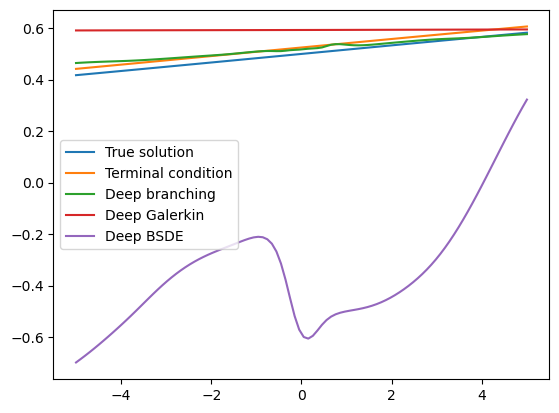

In [11]:
T=0.45
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 168 seconds; L1 error: 1.87E-02; L2 error: 5.08E-04; rel error: 3.98E-02.
fdb runtime: 552 seconds; total runtime: 720 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 504 seconds; L1 error: 1.03E-01; L2 error: 1.30E-02; rel error: 2.18E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 120 seconds; L1 error: 4.29E-01; L2 error: 3.17E-01; rel error: 9.12E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 178 seconds; L1 error: 2.02E-02; L2 error: 6.48E-04; rel error: 4.36E-02.
fdb runtime: 811 seconds; total runtime: 988 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 500 seconds; L1 error: 1.04E-01; L2 error: 1.32E-02; rel error: 2.20E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 109 seconds; L1 error: 5.21E-01; L2 error: 4.08E-01; rel error: 1.10E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 161 seconds; L1 error: 2.43E-02; L2 error: 8.22E-04; rel error: 5.18E-02.
fdb runtime: 443 seconds; total runtime: 604 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 505 seconds; L1 error: 1.00E-01; L2 error: 1.22E-02; rel error: 2.11E-01.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 116 seconds; L1 error: 2.18E+00; L2 error: 5.85E+00; rel error: 4.50E+00.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 159 seconds; L1 error: 2.34E-02; L2 error: 7.73E-04; rel error: 5.01E-02.
fdb runtime: 578 seconds; total runtime: 737 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 496 seconds; L1 error: 1.04E-01; L2 error: 1.28E-02; rel error: 2.18E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 115 seconds; L1 error: 4.34E-01; L2 error: 2.91E-01; rel error: 8.58E-01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 188 seconds; L1 error: 2.13E-02; L2 error: 5.97E-04; rel error: 4.52E-02.
fdb runtime: 630 seconds; total runtime: 819 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 515 seconds; L1 error: 1.05E-01; L2 error: 1.31E-02; rel error: 2.20E-01.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times
Time taken: 121 seconds; L1 error: 8.25E-01; L2 error: 9.01E-01; rel error: 1.69E+00.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 162 seconds; L1 error: 2.22E-02; L2 error: 8.26E-04; rel error: 4.82E-02.
fdb runtime: 841 seconds; total runtime: 1003 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 497 seconds; L1 error: 1.05E-01; L2 error: 1.33E-02; rel error: 2.21E-01.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times
Time taken: 118 seconds; L1 error: 6.24E-01; L2 error: 6.27E-01; rel error: 1.20E+00.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 186 seconds; L1 error: 2.32E-02; L2 error: 8.38E-04; rel error: 5.01E-02.
fdb runtime: 710 seconds; total runtime: 896 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 499 seconds; L1 error: 1.04E-01; L2 error: 1.30E-02; rel error: 2.19E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times
Time taken: 120 seconds; L1 error: 2.18E+00; L2 error: 6.01E+00; rel error: 4.52E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 148 seconds; L1 error: 2.30E-02; L2 error: 6.72E-04; rel error: 4.86E-02.
fdb runtime: 673 seconds; total runtime: 821 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 489 seconds; L1 error: 9.88E-02; L2 error: 1.19E-02; rel error: 2.09E-01.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times
Time taken: 107 seconds; L1 error: 8.86E-01; L2 error: 9.78E-01; rel error: 1.87E+00.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 175 seconds; L1 error: 2.26E-02; L2 error: 7.54E-04; rel error: 4.86E-02.
fdb runtime: 461 seconds; total runtime: 636 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 505 seconds; L1 error: 1.05E-01; L2 error: 1.34E-02; rel error: 2.22E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times
Time taken: 115 seconds; L1 error: 9.90E-01; L2 error: 1.23E+00; rel error: 2.05E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nicolas/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 186 seconds; L1 error: 2.09E-02; L2 error: 6.91E-04; rel error: 4.52E-02.
fdb runtime: 648 seconds; total runtime: 834 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 518 seconds; L1 error: 1.04E-01; L2 error: 1.32E-02; rel error: 2.20E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 120 seconds; L1 error: 2.58E+00; L2 error: 7.37E+00; rel error: 5.11E+00.




######## Summary for deep branching method
runtime:        171
fdb runtime:    635
total runtime:  806
mean L1 error:  2.20E-02
std L1 error:   1.61E-03
mean L2 error:  7.13E-04
std L2 error:   1.04E-04
mean rel error: 4.71E-02
std rel error:  3.44E-03


######## Summary for deep galerkin method
runtime:        503
mean L1 error:  1.03E-01
std L1 error:   2.02E-03
mean L2 error:  1.29E-02
std L2 error:   4.63E-04
mean rel error: 2.18E-01
std rel error:  4.17E-03


######## Summary for deep BSDE method
runtime:        116
mean L1 error:  1.16E+00


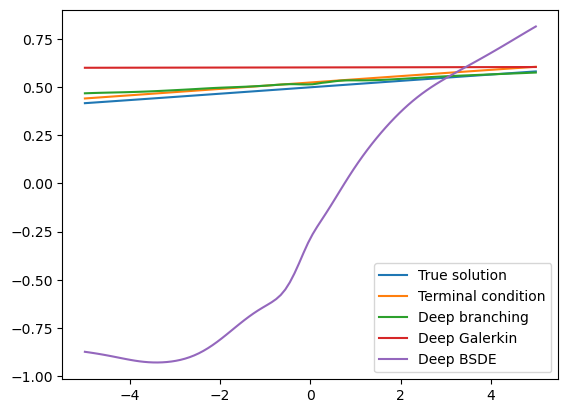

In [12]:
T=0.50
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)